In [1]:
!pip install catboost sklearn seaborn

In [2]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
# бибилиотеки для работы с графикой
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df= pd.read_csv("filtred_data.csv", index_col=0)

## Пустые значения

In [6]:
plt.figure(figsize=(21,8))
sns.set_style('whitegrid')
sns.heatmap(df.isnull(), cmap = 'viridis', yticklabels = False, cbar = False)

<AxesSubplot:ylabel='id'>

In [5]:
target_col_name = 'price'
target = df[target_col_name]
# for classification
#target_names = list(target.unique())

## Количество элементов по признакам

<AxesSubplot:xlabel='price', ylabel='count'>

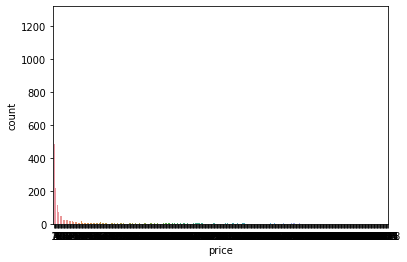

In [28]:
# for classification
#sns.countplot(target_names)
sns.countplot(target.value_counts())

In [30]:
feature_with_na_values = [feature for feature in df.columns if df[feature].isnull().sum()>1]
for feature in feature_with_na_values:
    print(feature, np.round(df[feature].isnull().mean(),4), '% пропущенных значений')

country 0.0 % пропущенных значений
district 0.0 % пропущенных значений


## Общая информаци о датасете

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403487 entries, 1 to 403487
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   sub_type           403487 non-null  object 
 1   start_date         403487 non-null  object 
 2   end_date           403487 non-null  object 
 3   listing_type       403487 non-null  int64  
 4   tom                403487 non-null  int64  
 5   building_age       403487 non-null  int64  
 6   total_floor_count  403487 non-null  int64  
 7   floor_no           403487 non-null  int64  
 8   room_count         403487 non-null  object 
 9   size               403487 non-null  float64
 10  heating_type       403487 non-null  int64  
 11  price              403487 non-null  float64
 12  city               403487 non-null  object 
 13  country            403480 non-null  object 
 14  district           403471 non-null  object 
dtypes: float64(2), int64(6), object(7)
memory usage: 49

Количество категориальных и числовых признаков

In [6]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
len(categorical_features)

7

In [7]:
numerical_features = [feature for feature in df.columns if feature not in categorical_features]
len(numerical_features)

8

In [8]:
df.describe()

,listing_type,tom,building_age,total_floor_count,floor_no,size,heating_type,price
count,403487.000000,403487.000000,403487.000000,403487.000000,403487.000000,403487.000000,403487.000000,4.034870e+05
mean,1.294235,57.022739,6.348720,5.335927,1.158711,177.901836,6.484345,3.540132e+05
std,0.467733,44.358933,8.596851,4.303609,4.965645,7533.583362,2.469843,4.805263e+06
min,1.000000,0.000000,-1.000000,-1.000000,-15.000000,-1.000000,0.000000,-2.500000e+02
25%,1.000000,29.000000,0.000000,3.000000,-1.000000,-1.000000,6.000000,2.500000e+03
50%,1.000000,40.000000,2.000000,4.000000,2.000000,85.000000,6.000000,1.990000e+05
75%,2.000000,90.000000,8.000000,6.000000,3.000000,124.000000,7.000000,3.400000e+05
max,3.000000,180.000000,40.000000,20.000000,20.000000,948235.000000,14.000000,2.000000e+09


## Предобработка и словари

Перечень полей типа 'object'

In [9]:
objectType = list(df.select_dtypes(['object']).columns)
objectType

['sub_type',
 'start_date',
 'end_date',
 'room_count',
 'city',
 'country',
 'district']

Перечень полей типа 'bool'

In [10]:
boolType = list(df.select_dtypes(['bool']).columns)
boolType

[]

## Заменяем строки классами от классификатора

In [13]:
les = {}
for name in df.columns:
    if df[name].dtypes == object or df[name].dtypes == bool:
        df[name].fillna("-9999999")
        les[name] = preprocessing.LabelEncoder()
        df[name] = les[name].fit_transform(df[name].apply(str))

In [14]:
df

,sub_type,start_date,end_date,listing_type,tom,building_age,total_floor_count,floor_no,room_count,size,heating_type,price,city,country,district
id,,,,,,,,,,,,,,,
1,7,93,31,2,30,0,20,2,12,90.0,0,3500.0,78,249,2447
2,0,127,0,1,14,0,20,20,2,43.0,0,490000.0,78,249,2447
3,0,61,91,1,30,0,1,1,12,-1.0,0,155000.0,66,489,3254
4,7,152,33,1,30,3,20,20,22,450.0,0,32500000.0,78,88,2747
5,7,93,31,1,30,0,20,2,12,90.0,0,1450000.0,78,249,2447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403483,0,160,0,2,162,-1,-1,-1,0,-1.0,14,1500.0,78,394,96
403484,0,33,0,1,139,-1,-1,-1,12,-1.0,14,120000.0,61,4,1012
403485,0,76,0,1,97,-1,-1,-1,3,-1.0,14,48000.0,6,22,3332


# Обучение модели CatBoost

In [15]:
y = target.to_numpy()
X = df.drop(target_col_name, axis = 1).to_numpy() 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=1)

In [16]:
model = CatBoostClassifier(iterations=100,)

In [ ]:
cat = model.fit(X_train, y_train)

Learning rate set to 0.5


In [26]:
model.score(X_test, y_test)

0.9401709401709402

In [27]:
y_pred = model.predict(X_test)
#print(classification_report(y_test, y_pred, target_names=target_names))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89        41
           1       0.86      0.87      0.87       102
           2       0.97      0.99      0.98      1082
           3       0.98      0.90      0.94       205
           4       0.50      1.00      0.67         1
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           8       1.00      0.97      0.99        40
           9       0.00      0.00      0.00         2
          10       1.00      0.88      0.93         8
          11       0.89      0.76      0.82       127
          12       0.24      0.45      0.31        20
          13       0.00      0.00      0.00         3
          14       1.00      1.00      1.00         4

    accuracy                           0.94      1638
   macro avg       0.59      0.63      0.60      1638
weighted avg       0.94      0.94      0.94      1638



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Экпорт модели

In [28]:
from sklearn.externals import joblib

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [29]:
joblib.dump(model, "model.pkl")

['model.pkl']

In [30]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,7,31.818595
1,0,14.403825
2,8,10.541014
3,2,6.664685
4,23,6.654343
5,3,4.963683
6,9,4.732878
7,12,4.160098
8,10,3.718944
9,1,3.712207


In [31]:
res = model.get_feature_importance()

In [32]:
res

array([1.44038248e+01, 3.71220653e+00, 6.66468455e+00, 4.96368311e+00,
       1.57925955e+00, 7.39975410e-01, 1.11982027e+00, 3.18185951e+01,
       1.05410135e+01, 4.73287823e+00, 3.71894403e+00, 2.43792096e-01,
       4.16009784e+00, 6.84324691e-04, 5.44405204e-01, 2.87344803e-01,
       1.09755943e-02, 1.08839662e-01, 2.75215824e+00, 2.85155543e-03,
       0.00000000e+00, 1.18709279e+00, 5.25300846e-02, 6.65434265e+00])

In [33]:
u = df.drop("CurElementMark", axis = 1).columns

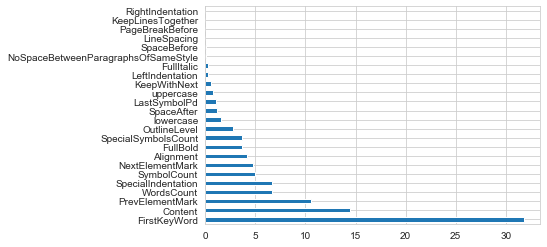

In [34]:
%matplotlib inline  
(pd.Series(res, index=u)
   .nlargest(100)
  .plot(kind='barh')
)

# Проверка модели на для NEXT

RightIndentation превращаем в object, так как по-умолчанию это int64

Надо либо в исходном датасете преобразовать в int либо тут в object

TODO Преобразовать в первом датасете в int

In [35]:
pd.options.display.max_rows = 999

In [36]:
test= pd.read_csv("test_libre-all.csv", skipinitialspace=True, sep=";", dtype={'RightIndentation': object, "SpaceAfter" : object})

In [37]:
testNext = test.drop("PrevElementMark", axis = 1)
testNext = testNext.drop("Content", axis = 1)
#testNext

In [38]:
testNext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 24 columns):
SpecialSymbolsCount                    210 non-null int64
WordsCount                             210 non-null int64
SymbolCount                            210 non-null int64
lowercase                              210 non-null bool
uppercase                              210 non-null bool
LastSymbolPd                           145 non-null object
FirstKeyWord                           103 non-null object
CurElementMark                         210 non-null object
NextElementMark                        210 non-null object
Столбец1                               0 non-null float64
FullBold                               210 non-null bool
FullItalic                             210 non-null bool
Alignment                              210 non-null object
KeepLinesTogether                      210 non-null bool
KeepWithNext                           210 non-null bool
LeftIndentation           

In [39]:
testNext_predict_original = testNext["CurElementMark"]

In [40]:
objectTypeTest = list(testNext.select_dtypes(['object']).columns)
objectTypeTest

['LastSymbolPd',
 'FirstKeyWord',
 'CurElementMark',
 'NextElementMark',
 'Alignment',
 'LeftIndentation',
 'LineSpacing',
 'OutlineLevel',
 'RightIndentation',
 'SpaceAfter',
 'SpecialIndentation']

In [41]:
boolTypeTest = list(testNext.select_dtypes(['bool']).columns)
boolType

['lowercase',
 'uppercase',
 'FullBold',
 'FullItalic',
 'KeepLinesTogether',
 'KeepWithNext',
 'NoSpaceBetweenParagraphsOfSameStyle',
 'PageBreakBefore']

In [42]:
def preprocess_test(test, mappings,boolTypeTest,objectTypeTest):
    for i in boolTypeTest:
        test[i] = test[i].map(int)
    for i in objectTypeTest:
        test[i] = test[i].fillna('0')
        mapForItem = mappings[i]
        test[i] =  test[i].map(mapForItem)
    return test

In [43]:
dataTestNext = preprocess_test(testNext, mappings,boolTypeTest,objectTypeTest )

In [44]:
model = joblib.load("model.pkl")

In [45]:
TestNext_pred= model.predict(dataTestNext, prediction_type="Class")

In [46]:
testNext_predict_original = pd.DataFrame(testNext_predict_original)
testNext_predict_original

,CurElementMark
0,b1
1,c1
2,c1
3,c2
4,d2
5,d2
6,d3
7,c1
8,c1
9,c2


In [47]:
testNext_predict_original['predict'] = TestNext_pred
testNext_predict_original

,CurElementMark,predict
0,b1,0
1,c1,2
2,c1,2
3,c2,2
4,d2,2
5,d2,2
6,d3,2
7,c1,2
8,c1,2
9,c2,2


In [48]:
mapCurElementMark = {v:k for k, v in mappings["CurElementMark"].items()} # меняем местами ключ-значение
testNext_predict_original['predict'] = testNext_predict_original['predict'].map(mapCurElementMark)

In [49]:
testNext_predict_original

,CurElementMark,predict
0,b1,b1
1,c1,c0
2,c1,c0
3,c2,c0
4,d2,c0
5,d2,c0
6,d3,c0
7,c1,c0
8,c1,c0
9,c2,c0


In [50]:
def inverse_test(test, mappings):
    for i in boolTypeTest:
        test[i] = test[i].map({1:"True", 0: "False"})
    for i in objectTypeTest:
        mapForItem = {v:k for k, v in mappings[i].items()}
        test[i] =  test[i].map(mapForItem)
    return test

In [51]:
testNext = inverse_test(testNext, mappings)
testNext

,SpecialSymbolsCount,WordsCount,SymbolCount,lowercase,uppercase,LastSymbolPd,FirstKeyWord,CurElementMark,NextElementMark,Столбец1,...,KeepWithNext,LeftIndentation,LineSpacing,NoSpaceBetweenParagraphsOfSameStyle,OutlineLevel,PageBreakBefore,RightIndentation,SpaceAfter,SpaceBefore,SpecialIndentation
0,0,1,8,False,False,0,TitleLevel1,b1,NaN,NaN,...,False,0,"1,5",False,Level1,False,0,0,0,0
1,5,28,271,False,False,.,0,NaN,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
2,8,39,373,False,False,.,0,NaN,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
3,4,19,163,False,False,:,0,NaN,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
4,3,4,41,True,False,;,listLevel1,NaN,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
5,2,5,50,True,False,;,listLevel1,NaN,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
6,3,7,63,True,False,.,listLevel1,NaN,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
7,14,53,492,False,False,.,0,NaN,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
8,12,79,674,False,False,.,0,NaN,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
9,1,11,74,False,False,:,0,NaN,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"


In [52]:
testNext['predict'] = TestNext_pred
testNext['predict'] = testNext['predict'].map(mapCurElementMark)

In [53]:
test.to_csv("predict-next.csv",index=True, header = True, sep=";")

# Проверка модели на для PREV

In [54]:
test= pd.read_csv("test_libre-all.csv", skipinitialspace=True, sep=";", dtype={'RightIndentation': object, "SpaceAfter" : object})

In [55]:
test.columns

Index(['Content', 'SpecialSymbolsCount', 'WordsCount', 'SymbolCount',
       'lowercase', 'uppercase', 'LastSymbolPd', 'FirstKeyWord',
       'PrevElementMark', 'CurElementMark', 'NextElementMark', 'Столбец1',
       'FullBold', 'FullItalic', 'Alignment', 'KeepLinesTogether',
       'KeepWithNext', 'LeftIndentation', 'LineSpacing',
       'NoSpaceBetweenParagraphsOfSameStyle', 'OutlineLevel',
       'PageBreakBefore', 'RightIndentation', 'SpaceAfter', 'SpaceBefore',
       'SpecialIndentation'],
      dtype='object')

In [56]:
testPrev_predict_original = test["CurElementMark"]

In [57]:
testPrev = test.drop(["NextElementMark","Content"], axis = 1)
#testPrev = testPrev.drop([], axis = 1)
#testPrev

In [58]:
testPrev.columns

Index(['SpecialSymbolsCount', 'WordsCount', 'SymbolCount', 'lowercase',
       'uppercase', 'LastSymbolPd', 'FirstKeyWord', 'PrevElementMark',
       'CurElementMark', 'Столбец1', 'FullBold', 'FullItalic', 'Alignment',
       'KeepLinesTogether', 'KeepWithNext', 'LeftIndentation', 'LineSpacing',
       'NoSpaceBetweenParagraphsOfSameStyle', 'OutlineLevel',
       'PageBreakBefore', 'RightIndentation', 'SpaceAfter', 'SpaceBefore',
       'SpecialIndentation'],
      dtype='object')

In [59]:
testPrev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 24 columns):
SpecialSymbolsCount                    210 non-null int64
WordsCount                             210 non-null int64
SymbolCount                            210 non-null int64
lowercase                              210 non-null bool
uppercase                              210 non-null bool
LastSymbolPd                           145 non-null object
FirstKeyWord                           103 non-null object
PrevElementMark                        210 non-null object
CurElementMark                         210 non-null object
Столбец1                               0 non-null float64
FullBold                               210 non-null bool
FullItalic                             210 non-null bool
Alignment                              210 non-null object
KeepLinesTogether                      210 non-null bool
KeepWithNext                           210 non-null bool
LeftIndentation           

In [60]:
objectTypeTest = list(testPrev.select_dtypes(['object']).columns)
objectTypeTest 

['LastSymbolPd',
 'FirstKeyWord',
 'PrevElementMark',
 'CurElementMark',
 'Alignment',
 'LeftIndentation',
 'LineSpacing',
 'OutlineLevel',
 'RightIndentation',
 'SpaceAfter',
 'SpecialIndentation']

In [61]:
boolTypeTest = list(testPrev.select_dtypes(['bool']).columns)
boolTypeTest

['lowercase',
 'uppercase',
 'FullBold',
 'FullItalic',
 'KeepLinesTogether',
 'KeepWithNext',
 'NoSpaceBetweenParagraphsOfSameStyle',
 'PageBreakBefore']

In [62]:
testPrev.columns

Index(['SpecialSymbolsCount', 'WordsCount', 'SymbolCount', 'lowercase',
       'uppercase', 'LastSymbolPd', 'FirstKeyWord', 'PrevElementMark',
       'CurElementMark', 'Столбец1', 'FullBold', 'FullItalic', 'Alignment',
       'KeepLinesTogether', 'KeepWithNext', 'LeftIndentation', 'LineSpacing',
       'NoSpaceBetweenParagraphsOfSameStyle', 'OutlineLevel',
       'PageBreakBefore', 'RightIndentation', 'SpaceAfter', 'SpaceBefore',
       'SpecialIndentation'],
      dtype='object')

In [63]:
dataTestPrev = preprocess_test(testPrev, mappings,boolTypeTest,objectTypeTest )

In [64]:
model = joblib.load("model.pkl")
testPrev_pred= model.predict(dataTestPrev, prediction_type="Class")

In [65]:
testPrev_predict_original = pd.DataFrame(testPrev_predict_original)
testPrev_predict_original

,CurElementMark
0,b1
1,c1
2,c1
3,c2
4,d2
5,d2
6,d3
7,c1
8,c1
9,c2


In [66]:
testPrev_predict_original['predict'] = testPrev_pred
testPrev_predict_original

,CurElementMark,predict
0,b1,0
1,c1,2
2,c1,2
3,c2,2
4,d2,2
5,d2,2
6,d3,2
7,c1,2
8,c1,2
9,c2,2


In [67]:
mapCurElementMark = {v:k for k, v in mappings["CurElementMark"].items()} # меняем местами ключ-значение
testPrev_predict_original['predict'] = testPrev_predict_original['predict'].map(mapCurElementMark)

In [68]:
testPrev_predict_original

,CurElementMark,predict
0,b1,b1
1,c1,c0
2,c1,c0
3,c2,c0
4,d2,c0
5,d2,c0
6,d3,c0
7,c1,c0
8,c1,c0
9,c2,c0


In [69]:
def inverse_test(test, mappings):
    for i in boolTypeTest:
        test[i] = test[i].map({1:"True", 0: "False"})
    for i in objectTypeTest:
        mapForItem = {v:k for k, v in mappings[i].items()}
        test[i] =  test[i].map(mapForItem)
    return test

In [70]:
testPrev = inverse_test(testPrev, mappings)
testPrev

,SpecialSymbolsCount,WordsCount,SymbolCount,lowercase,uppercase,LastSymbolPd,FirstKeyWord,PrevElementMark,CurElementMark,Столбец1,...,KeepWithNext,LeftIndentation,LineSpacing,NoSpaceBetweenParagraphsOfSameStyle,OutlineLevel,PageBreakBefore,RightIndentation,SpaceAfter,SpaceBefore,SpecialIndentation
0,0,1,8,False,False,0,TitleLevel1,NaN,b1,NaN,...,False,0,"1,5",False,Level1,False,0,0,0,0
1,5,28,271,False,False,.,0,b1,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
2,8,39,373,False,False,.,0,NaN,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
3,4,19,163,False,False,:,0,NaN,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
4,3,4,41,True,False,;,listLevel1,NaN,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
5,2,5,50,True,False,;,listLevel1,NaN,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
6,3,7,63,True,False,.,listLevel1,NaN,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
7,14,53,492,False,False,.,0,NaN,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
8,12,79,674,False,False,.,0,NaN,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"
9,1,11,74,False,False,:,0,NaN,NaN,NaN,...,False,0,"1,5",False,BodyText,False,0,0,0,"-35,45"


In [71]:
testPrev['predict'] = testPrev_pred
testPrev['predict'] = testPrev['predict'].map(mapCurElementMark)

In [72]:
test.to_csv("predict-prev.csv",index=True, header = True, sep=";")

# Графики

## Корреляционные матрицы

In [73]:
df.corr()

,Content,SpecialSymbolsCount,WordsCount,SymbolCount,lowercase,uppercase,LastSymbolPd,FirstKeyWord,PrevElementMark,CurElementMark,...,KeepWithNext,LeftIndentation,LineSpacing,NoSpaceBetweenParagraphsOfSameStyle,OutlineLevel,PageBreakBefore,RightIndentation,SpaceAfter,SpaceBefore,SpecialIndentation
Content,1.000000,0.082583,0.129151,0.133210,-0.366075,-0.139011,-0.277820,-0.186242,0.171234,0.270303,...,-0.200095,-0.030946,0.111510,-0.253936,-0.202714,-0.050522,0.027642,0.044559,-0.087320,0.029133
SpecialSymbolsCount,0.082583,1.000000,0.906523,0.906996,-0.145920,-0.132788,-0.371885,-0.342984,-0.155741,-0.219874,...,-0.162492,-0.062417,0.102398,-0.049860,-0.170927,-0.061523,0.056802,-0.110338,-0.114170,-0.327805
WordsCount,0.129151,0.906523,1.000000,0.992030,-0.192034,-0.120118,-0.423114,-0.388097,-0.153616,-0.222153,...,-0.165416,-0.071950,0.120825,-0.086068,-0.179148,-0.057603,0.068760,-0.114058,-0.127836,-0.337254
SymbolCount,0.133210,0.906996,0.992030,1.000000,-0.196914,-0.122053,-0.436554,-0.409101,-0.177658,-0.241154,...,-0.168347,-0.077360,0.133304,-0.095005,-0.182626,-0.058403,0.070379,-0.118544,-0.124760,-0.349760
lowercase,-0.366075,-0.145920,-0.192034,-0.196914,1.000000,-0.043599,0.506187,0.356337,-0.051437,0.002659,...,-0.067160,-0.024136,0.050899,0.328902,-0.073398,-0.019769,-0.073087,-0.058046,-0.079038,0.005250
uppercase,-0.139011,-0.132788,-0.120118,-0.122053,-0.043599,1.000000,0.043102,0.020255,-0.038924,0.008978,...,0.251295,0.023907,-0.055825,-0.041844,0.169622,0.350359,0.020234,0.227080,0.118982,0.112401
LastSymbolPd,-0.277820,-0.371885,-0.423114,-0.436554,0.506187,0.043102,1.000000,0.479015,0.066459,0.171686,...,0.056610,0.011889,-0.140253,0.208129,0.064841,0.019543,-0.038191,0.041375,0.034236,0.137353
FirstKeyWord,-0.186242,-0.342984,-0.388097,-0.409101,0.356337,0.020255,0.479015,1.000000,0.354437,0.640898,...,0.100617,-0.006996,-0.273234,0.115095,0.126530,-0.007475,-0.075350,0.170737,0.018380,0.367662
PrevElementMark,0.171234,-0.155741,-0.153616,-0.177658,-0.051437,-0.038924,0.066459,0.354437,1.000000,0.576466,...,-0.049950,-0.006738,-0.114567,0.022073,-0.031045,-0.036862,-0.061050,0.183244,0.003495,0.244848
CurElementMark,0.270303,-0.219874,-0.222153,-0.241154,0.002659,0.008978,0.171686,0.640898,0.576466,1.000000,...,-0.185992,-0.024865,-0.139450,-0.086568,-0.191802,-0.072750,-0.059076,0.277942,-0.137425,0.342550


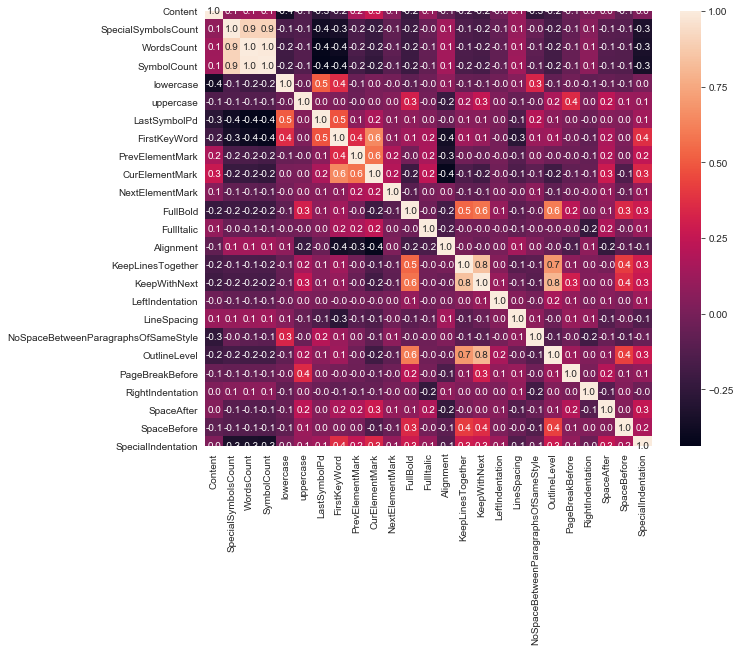

In [74]:
plt.figure(figsize = (10,8))
sns.heatmap(df.corr(), annot = True, fmt = ".1f")

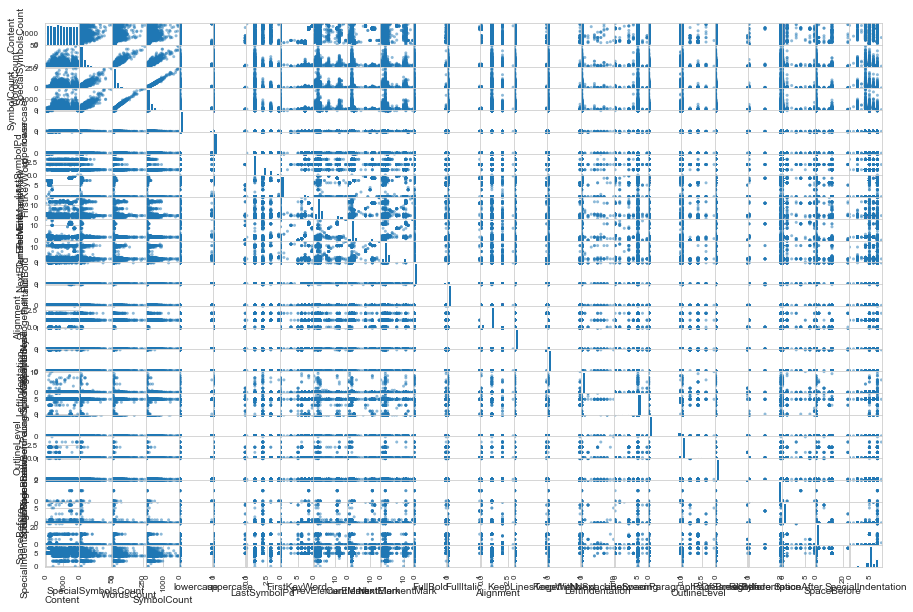

In [75]:
pd.plotting.scatter_matrix(df, figsize = (15,10));

In [76]:
from pandas_profiling import ProfileReport

In [77]:
profile = ProfileReport(df)

C:\ProgramData\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [78]:
profile.to_file("Отчет по датасету.html")

In [79]:
profile

Number of variables,25
Number of observations,1926
Total Missing (%),0.0%
Total size in memory,218.3 KiB
Average record size in memory,116.1 B
Numeric,15
Categorical,0
Boolean,8
Date,0
Text (Unique),0
Rejected,2
